1. IMPORTING LIBRARIES AND MODULES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, warnings, random, string
from pickle import dump, load
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.applications.inception_v3 import InceptionV3 , preprocess_input
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

In [4]:
from nltk import FreqDist
from nltk.translate.bleu_score import sentence_bleu

2. EXPLORATORY DATA ANALYSIS

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
input_dir = '/content/drive/MyDrive/Colab Notebooks'

In [6]:
def load_captions_dictionary(path):
    file = open(path, 'r')
    captions = file.read().split('\n')
    descriptions = {}
    for text in captions[1:]:
        values = text.split(',')
        img, caption = values[0].split('.')[0], "".join(values[1:])
        if img not in descriptions:
            descriptions[img] = [caption]
        else:
            descriptions[img].append(caption)
    file.close()
    return descriptions

descriptions = load_captions_dictionary(input_dir + '/captions.txt')

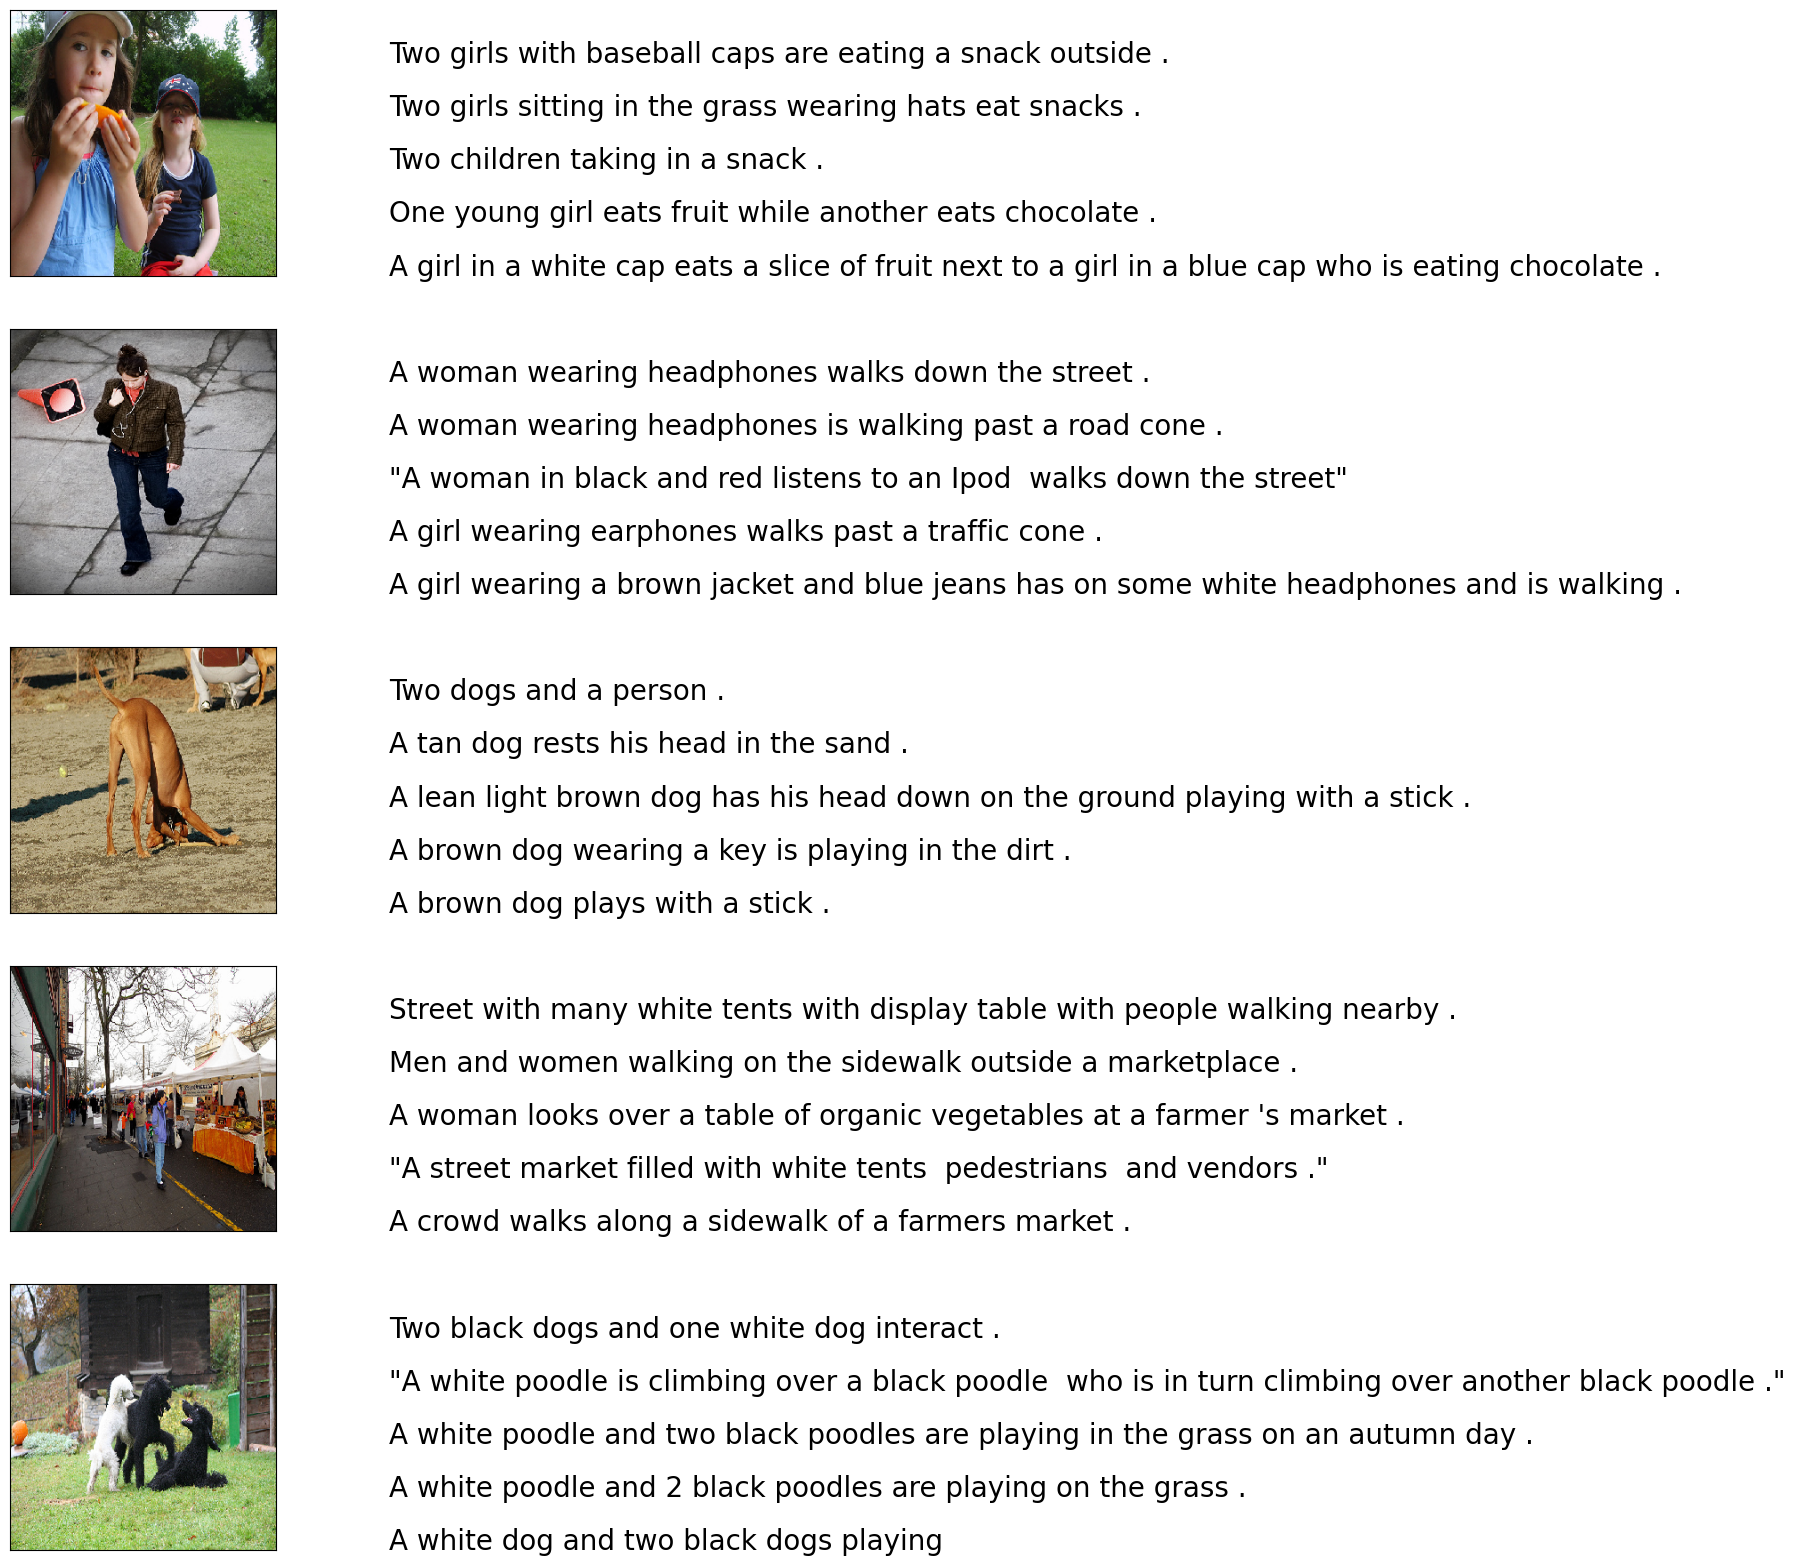

In [7]:
npic = 5
img_size = 299
target_size = (img_size, img_size)
path = input_dir + "/Images/"
fig = plt.figure(figsize=(10,20))

count = 1
for img in os.listdir(path)[:npic]:

    filename = path + img
    captions = list(descriptions[img.split(".")[0]])
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1
plt.show()

3. TEXT PROCESSING AND ANALYSIS

In [8]:
def text_cleaning(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for img, caption in descriptions.items():
        for i, img_text in enumerate(caption):
            img_text.replace("-", " ")
            text = [word.lower() for word in img_text.split()]
            text = [word.translate(table) for word in text]
            text = [word for word in text if(len(word) > 1)]
            text = [word for word in text if(word.isalpha())]
            img_text = " ".join(text)
            descriptions[img][i] = img_text
    return descriptions

descriptions = text_cleaning(descriptions)

In [9]:
def corpus_and_vocab(descriptions):
    corpus = ""
    for img_text in descriptions.values():
        for text in img_text:
            corpus += " "+text
    vocab = set(corpus.split())
    return corpus, vocab

corpus, vocab = corpus_and_vocab(descriptions)
print("Number of unique words = {}".format(len(vocab)))

Number of unique words = 8763


In [10]:
freq_dist = FreqDist(corpus.split())
dfsub = pd.DataFrame(columns = ["word", "count"])
most_common = freq_dist.most_common()
words, counts = [], []
for i in range(len(freq_dist)):
    words.append(most_common[i][0])
    counts.append(most_common[i][1])
dfsub["word"], dfsub["count"] = words, counts

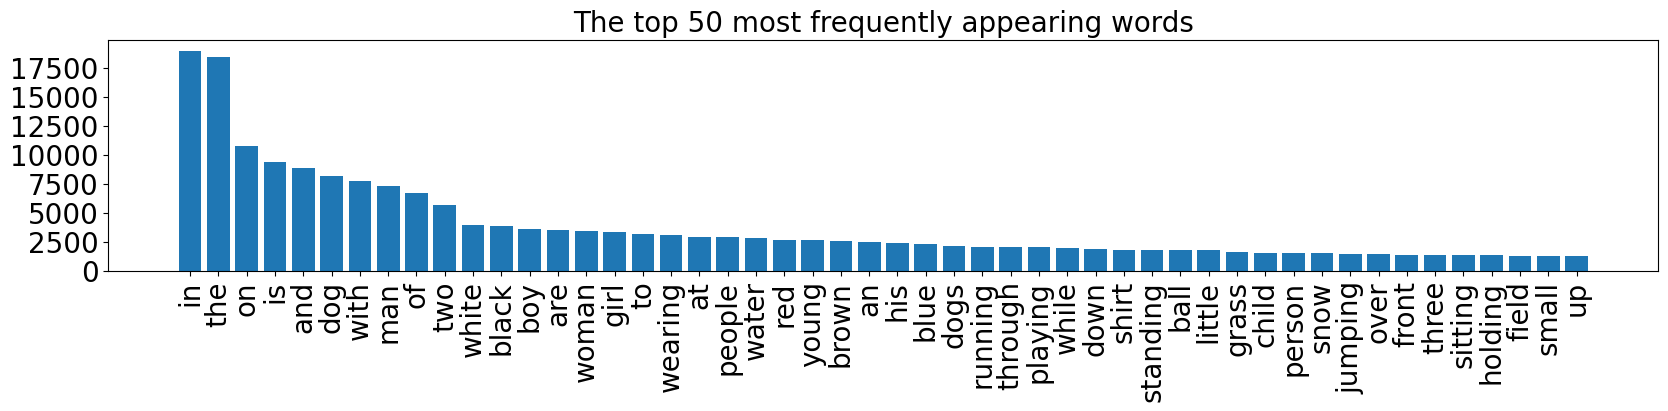

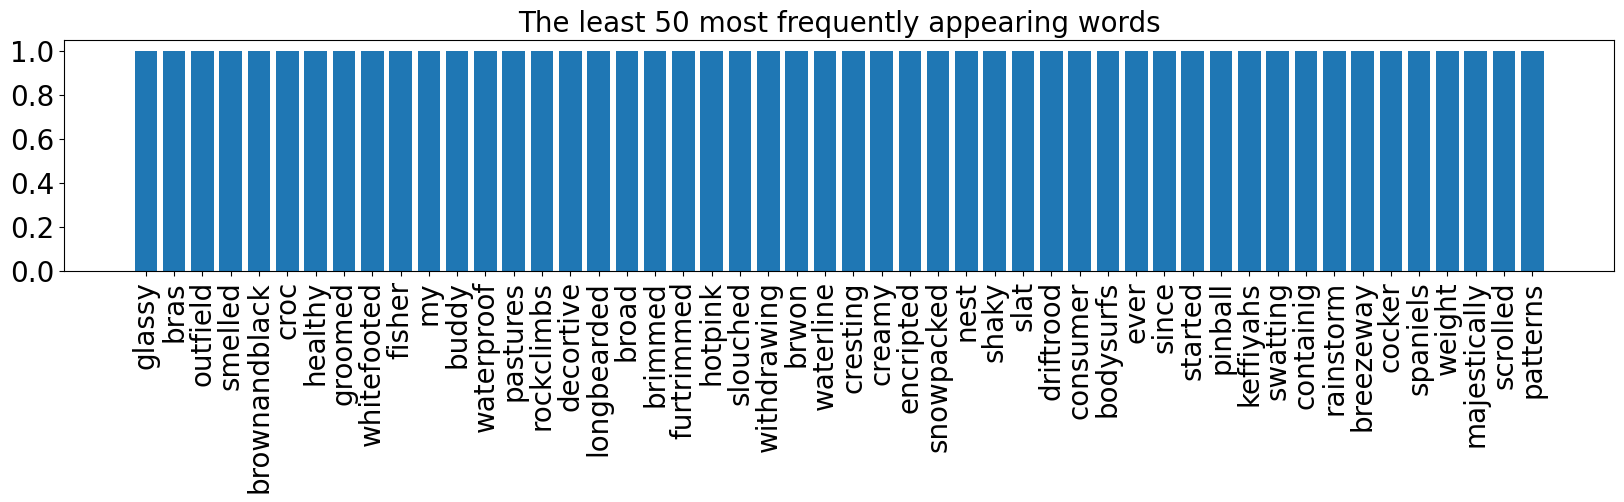

In [11]:
def plthist(dfsub, title):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfsub.iloc[:50], "The top 50 most frequently appearing words")
plthist(dfsub.iloc[-50:], "The least 50 most frequently appearing words")

In [12]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for i, desc in enumerate(desc_list):
            descriptions[key][i] = desc = "<startseq> " + desc + " <endseq>"
            lines.append(key + '\t' + desc)
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

save_descriptions(descriptions, "Image_Descriptions_List.txt")

4. TRAIN-VAL-TEST SPLIT

In [13]:
df_img_caption = pd.DataFrame()
df_img_caption['Image_Name'] = list(descriptions.keys())[:-1]
temps = list(descriptions.values())[:-1]
df_img_caption['Caption'] = [temps[i][random.randint(0,4)] for i in range(len(temps))]
df_img_caption.head()

,Image_Name,Caption
0,1000268201_693b08cb0e,<startseq> little girl in pink dress going int...
1,1001773457_577c3a7d70,<startseq> two dogs on pavement moving toward ...
2,1002674143_1b742ab4b8,<startseq> young girl with pigtails painting o...
3,1003163366_44323f5815,<startseq> man sleeping on bench outside with ...
4,1007129816_e794419615,<startseq> man with glasses is wearing beer ca...


In [14]:
test_images = np.asarray(df_img_caption['Image_Name'][:10], dtype = np.dtype(object))
test_captions = np.asarray(df_img_caption['Caption'][:10], dtype = np.dtype(object))
val_images = np.asarray(df_img_caption['Image_Name'][10:15], dtype = np.dtype(object))
val_captions = np.asarray(df_img_caption['Caption'][10:15], dtype = np.dtype(object))
train_images = np.asarray(df_img_caption['Image_Name'][15:], dtype = np.dtype(object))
train_captions = np.asarray(df_img_caption['Caption'][15:], dtype = np.dtype(object))

In [15]:
print("Test Images:")
print(test_images)
print()

print("Test Captions:")
print(test_captions)
print()

print("Validation Images:")
print(val_images)
print()

print("Validation Captions:")
print(val_captions)
print()

print("Train Images:")
print(train_images)
print()

print("Train Captions:")
print(train_captions)
print()

Test Images:
['1000268201_693b08cb0e' '1001773457_577c3a7d70' '1002674143_1b742ab4b8'
 '1003163366_44323f5815' '1007129816_e794419615' '1007320043_627395c3d8'
 '1009434119_febe49276a' '1012212859_01547e3f17' '1015118661_980735411b'
 '1015584366_dfcec3c85a']

Test Captions:
['<startseq> little girl in pink dress going into wooden cabin <endseq>'
 '<startseq> two dogs on pavement moving toward each other <endseq>'
 '<startseq> young girl with pigtails painting outside in the grass <endseq>'
 '<startseq> man sleeping on bench outside with white and black dog sitting next to him <endseq>'
 '<startseq> man with glasses is wearing beer can crocheted hat <endseq>'
 '<startseq> the small child climbs on red ropes on playground <endseq>'
 '<startseq> black and white dog is running in grassy garden surrounded by white fence <endseq>'
 '<startseq> white dog playing with red ball on the shore near the water <endseq>'
 '<startseq> little boy is standing on the street while man in overalls is workin

5. FEATURE EXTRACTION

In [16]:
cnn_model = InceptionV3(weights = 'imagenet')
for layer in cnn_model.layers:
    layer.trainable = False
cnn_model = Model(inputs = cnn_model.input, outputs = cnn_model.get_layer('avg_pool').output)
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:
def extract_features(model, images, img_size):
    features = {}
    for img in tqdm(images):
        picture = load_img(input_dir + "/Images/" + img + ".jpg", target_size = (img_size, img_size))
        picture = img_to_array(picture)
        picture = np.expand_dims(picture, axis = 0)
        picture = preprocess_input(picture)
        features[img] = model.predict(picture).reshape(2048,)

    return features

In [19]:
Xtrain_features_old = extract_features(cnn_model, train_images, 299)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
from itertools import islice

# Print the first 5 entries of Xtrain_features_old
n_entries = 5
for key, value in islice(Xtrain_features_old.items(), n_entries):
    print(key, value)

1020651753_06077ec457 [0.47514695 0.35221785 0.01383355 ... 0.20678705 0.06418364 0.3813913 ]
1022454332_6af2c1449a [0.49877214 0.5118381  0.5580944  ... 0.5969265  1.0398734  1.0383673 ]
1022454428_b6b660a67b [0.4963346  0.19245864 0.40163708 ... 0.93441814 0.73973936 0.06167341]
1022975728_75515238d8 [4.1625351e-01 1.8792881e-02 2.0406625e-01 ... 1.0387510e-03 1.2464402e+00
 3.7836775e-02]
102351840_323e3de834 [0.10465108 0.20573892 0.19238436 ... 0.15708302 0.43167925 0.26807696]


In [21]:
import pickle

# Save the Xtrain_features_old dictionary
with open('Xtrain_features_old.pkl', 'wb') as f:
    pickle.dump(Xtrain_features_old, f)

In [18]:
import pickle

with open('Xtrain_features_old.pkl', 'rb') as f:
    Xtrain_features_old = pickle.load(f)

In [19]:
Xtrain_features = np.array(list(Xtrain_features_old.values()))

In [20]:
Xval_features_old = extract_features(cnn_model, val_images, 299)

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


 20%|██        | 1/5 [00:02<00:11,  2.78s/it]

1/1 [==============================] - 0s 249ms/step


 40%|████      | 2/5 [00:03<00:04,  1.38s/it]

1/1 [==============================] - 1s 659ms/step


 60%|██████    | 3/5 [00:04<00:02,  1.17s/it]

1/1 [==============================] - 0s 264ms/step


 80%|████████  | 4/5 [00:04<00:00,  1.15it/s]

1/1 [==============================] - 1s 585ms/step


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


In [21]:
Xval_features = np.array(list(Xval_features_old.values()))

6. DATA PREPARATION

In [22]:
tokenizer = Tokenizer(num_words = len(vocab))
tokenizer.fit_on_texts(df_img_caption['Caption'])
word_to_index = tokenizer.word_index
index_to_word = dict([index, word] for word, index in word_to_index.items())
vocab_size = len(tokenizer.word_index) + 1

In [23]:
train_sequences = tokenizer.texts_to_sequences(train_captions)
val_sequences = tokenizer.texts_to_sequences(val_captions)

def maxLength(sequences):
    return np.max([len(sequence) for sequence in sequences])

max_len = max(maxLength(train_sequences), maxLength(val_sequences))

In [24]:
def data_generator(features, sequences):
    X_features, X_train, y_train = [], [], []
    for sequence, feature in zip(sequences, features):
        for i in range(1, len(sequence)):
            in_text, out_text = sequence[:i], sequence[i:]
            in_text = pad_sequences([in_text], maxlen = max_len)[0]
            out_text = to_categorical(out_text, num_classes = vocab_size)[0]
            X_features.append(feature)
            X_train.append(in_text)
            y_train.append(out_text)
    return (np.array(X_features), np.array(X_train), np.array(y_train))

Xt_features, Xt_text, yt_text = data_generator(Xtrain_features, train_sequences)
Xv_features, Xv_text, yv_text = data_generator(Xval_features, val_sequences)

In [25]:
print(Xt_features.shape, Xt_text.shape, yt_text.shape)
print(Xv_features.shape, Xv_text.shape, yv_text.shape)

(82390, 2048) (82390, 31) (82390, 4429)
(52, 2048) (52, 31) (52, 4429)


7. RNN MODEL

In [26]:
def define_model(vocab_size, max_len):

    inputs1 = Input(shape = (2048,))
    x1 = Dropout(0.3)(inputs1)
    x2 = Dense(256, activation = 'relu')(x1)

    inputs2 = Input(shape = (max_len,))
    se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([x2, se3])
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

    rnn_model = Model(inputs = [inputs1, inputs2], outputs = outputs)
    rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

    print(rnn_model.summary())
    plot_model(rnn_model, to_file = 'rnn_model.png', show_shapes = True)

    return rnn_model

rnn_model = define_model(vocab_size, max_len)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 31, 256)      1133824     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [27]:
model_training = rnn_model.fit([Xt_features, Xt_text], yt_text,
                               epochs = 5, verbose = 2, batch_size = 64,
                               validation_data = ([Xv_features, Xv_text], yv_text))

Epoch 1/5
1288/1288 - 411s - loss: 4.9466 - val_loss: 3.4274 - 411s/epoch - 319ms/step
Epoch 2/5
1288/1288 - 398s - loss: 4.0567 - val_loss: 3.2232 - 398s/epoch - 309ms/step
Epoch 3/5
1288/1288 - 385s - loss: 3.6851 - val_loss: 2.9723 - 385s/epoch - 299ms/step
Epoch 4/5
1288/1288 - 386s - loss: 3.4170 - val_loss: 2.9497 - 386s/epoch - 300ms/step
Epoch 5/5
1288/1288 - 416s - loss: 3.2015 - val_loss: 2.8499 - 416s/epoch - 323ms/step


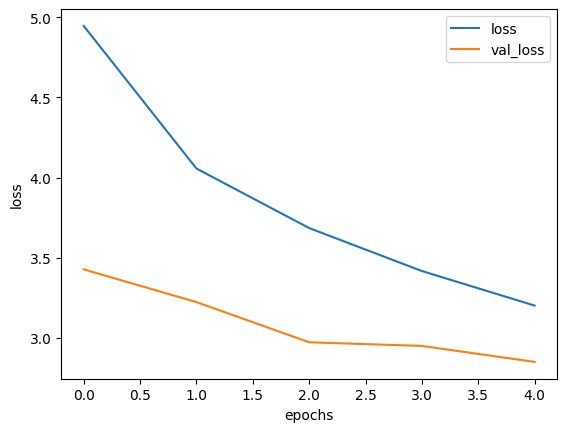

In [28]:
for label in ["loss", "val_loss"]:
    plt.plot(model_training.history[label], label = label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

8. SAVING FILES AND MODELS

In [29]:
rnn_model.save("RNN_Model.h5")
cnn_model.save("CNN_Model.h5")
dump(tokenizer, open('Flickr8K_Tokenizer.p', 'wb'))

9. PREDICTION & PERFORMANCE ANALYSIS

In [30]:
def generate_caption(filename):
    img = load_img(filename, target_size = (299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    features = cnn_model.predict(img)
    in_text = 'startseq'
    for i in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        pred = rnn_model.predict([features,sequence], verbose=0)
        pred = np.argmax(pred)
        word = index_to_word[pred]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [31]:
def generate_caption_beam_search(filename, max_length, beam_index):
    img = load_img(filename, target_size = (299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    features = cnn_model.predict(img)
    in_text = [[tokenizer.texts_to_sequences(['startseq'])[0], 0.0]]
    while len(in_text[0][0]) < max_length:
        tempList = []
        for seq in in_text:
            padded_seq = pad_sequences([seq[0]], maxlen=max_length)
            preds = rnn_model.predict([features,padded_seq], verbose=0)
            top_preds = np.argsort(preds[0])[-beam_index:]
            for word in top_preds:
                next_seq, prob = seq[0][:], seq[1]
                next_seq.append(word)
                prob += preds[0][word]
                tempList.append([next_seq, prob])
        in_text = tempList
        in_text = sorted(in_text, reverse=False, key=lambda l: l[1])
        in_text = in_text[-beam_index:]
    in_text = in_text[-1][0]
    final_caption_raw = [index_to_word[i] for i in in_text]
    final_caption = []
    for word in final_caption_raw:
        if word == 'endseq':
            break
        else:
            final_caption.append(word)
    final_caption.append('endseq')
    return ' '.join(final_caption)

1/1 [==============================] - 0s 268ms/step


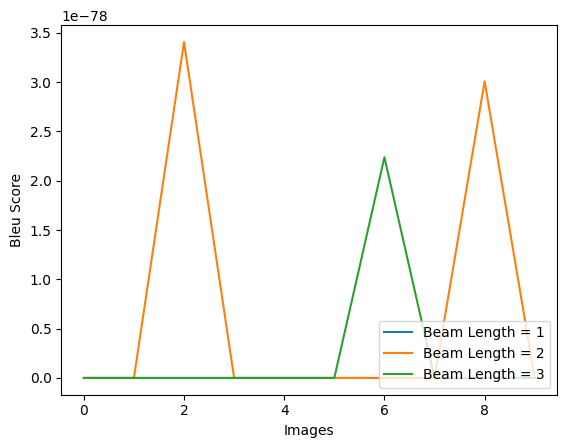

In [34]:
scores, beam2_scores, beam3_scores = [], [], []
for img, caption in zip(test_images, test_captions):
    hypothesis = generate_caption(input_dir + "/Images/" + img + ".jpg")
    scores.append(sentence_bleu([caption.split()], hypothesis.split()))
    hypothesis = generate_caption_beam_search(input_dir + "/Images/" + img + ".jpg", max_len, 2)
    beam2_scores.append(sentence_bleu([caption.split()], hypothesis.split()))
    hypothesis = generate_caption_beam_search(input_dir + "/Images/" + img + ".jpg", max_len, 3)
    beam3_scores.append(sentence_bleu([caption.split()], hypothesis.split()))

for i, score in enumerate([scores, beam2_scores, beam3_scores]):
    plt.plot(score, label = 'Beam Length = ' + str(i+1))
plt.legend(loc = 'lower right')
plt.xlabel('Images')
plt.ylabel('Bleu Score')
plt.show()

1/1 [==============================] - 0s 291ms/step


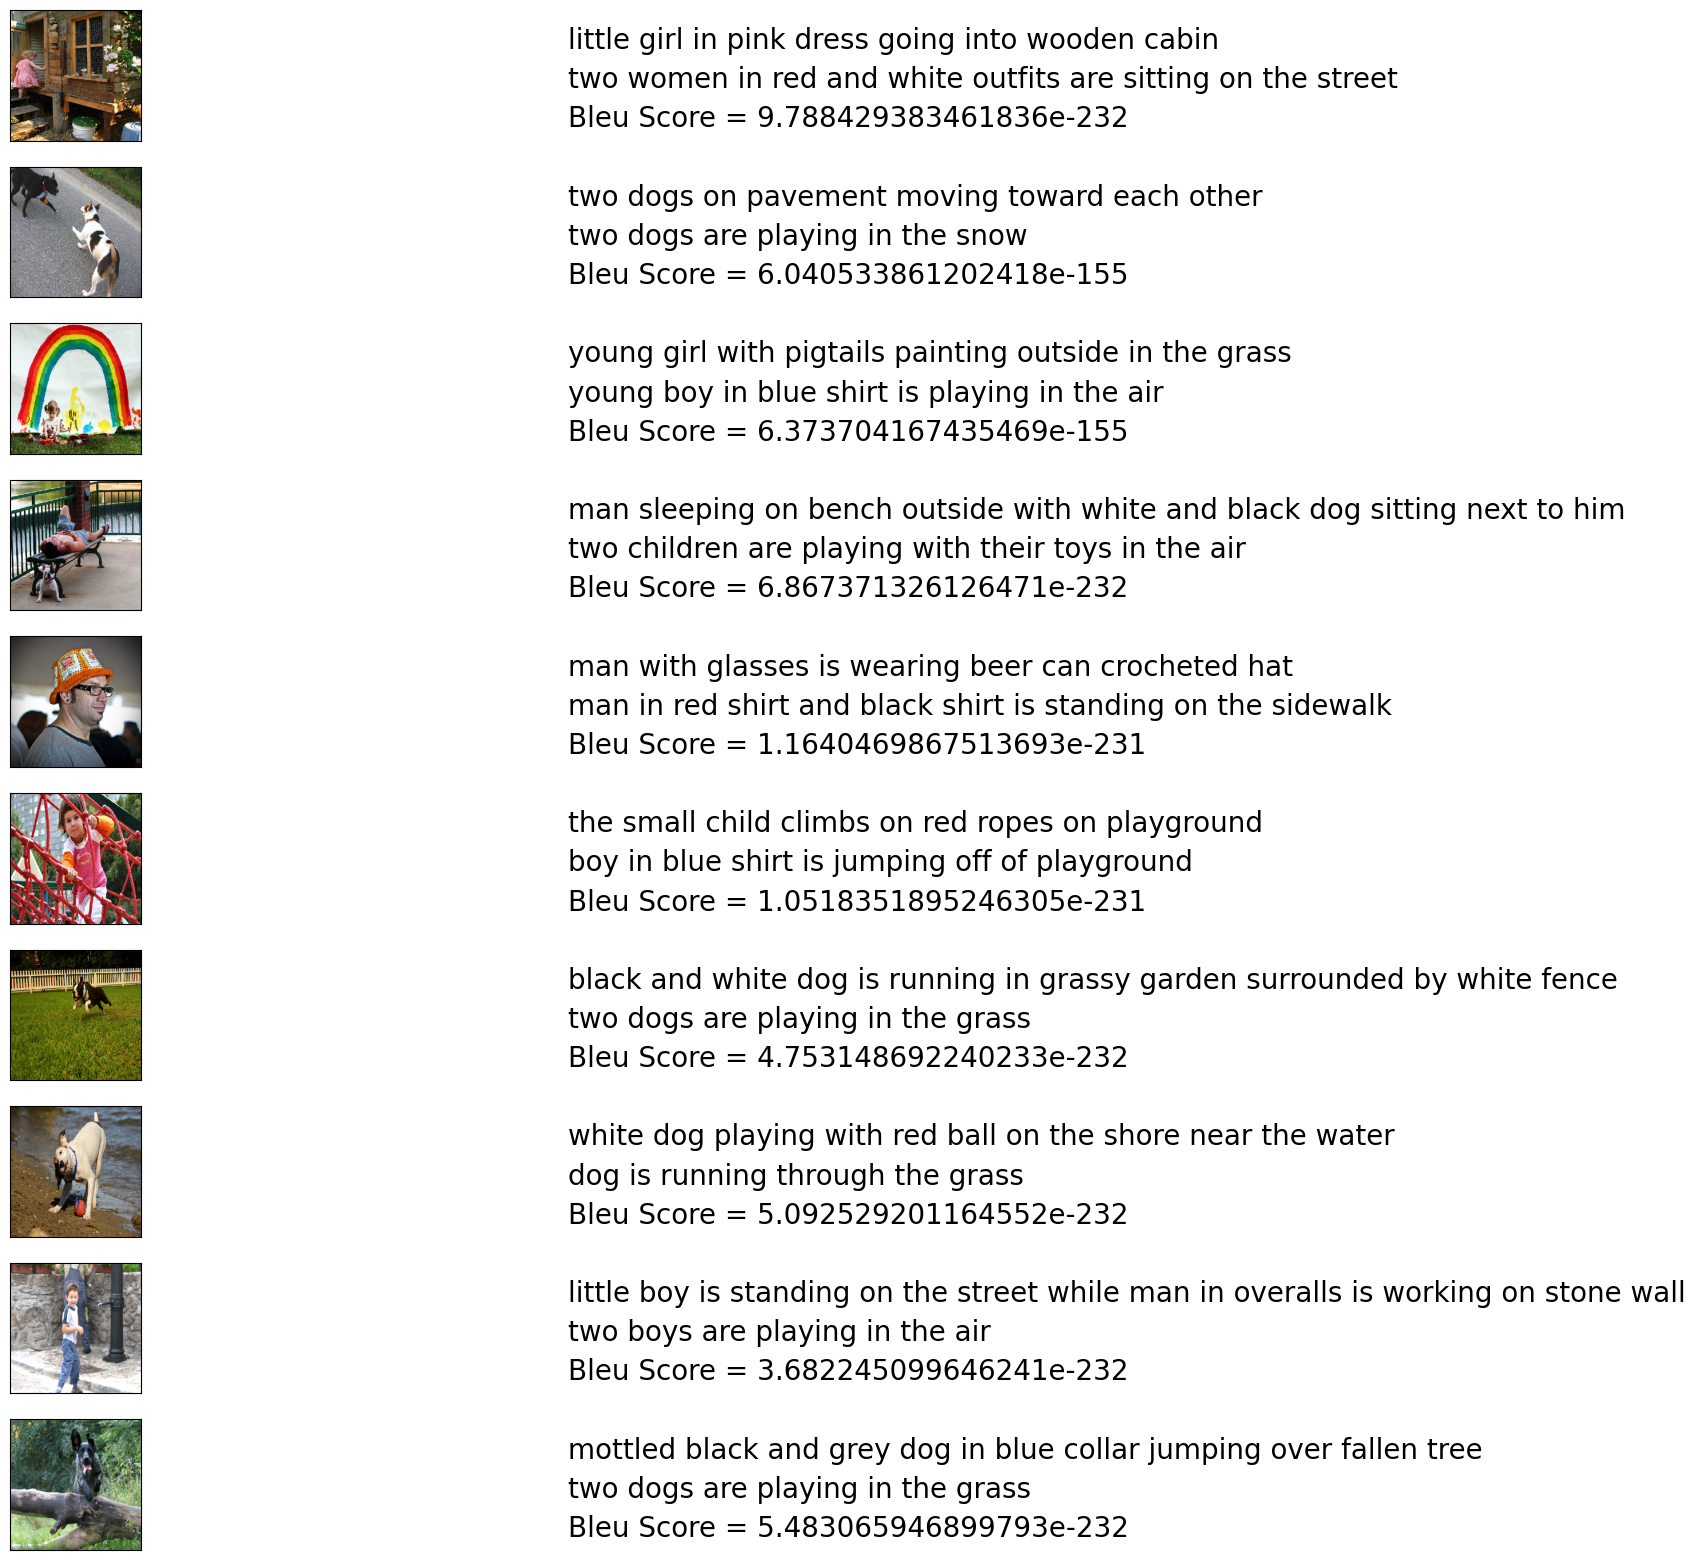

In [33]:
npic = 10
npix = 299
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(20,20))
for img, true_caption in zip(test_images, test_captions):

    filename = input_dir + '/Images/' + img + ".jpg"
    image_load = load_img(filename, target_size = target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    true_caption = ' '.join(true_caption.split()[1: -1])
    ax.imshow(image_load)
    count += 1

    caption = generate_caption(filename)
    caption = ' '.join(caption.split()[1: -1])
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0, 0.7, true_caption, fontsize = 20)
    ax.text(0, 0.4, caption, fontsize = 20)
    ax.text(0, 0.1, 'Bleu Score = {}'.format(sentence_bleu([true_caption.split()], caption.split())), fontsize = 20)
    count += 1

plt.show()

Output on random input images

Enter the path of the input image: /content/WIN_20220411_13_03_06_Pro.jpg
1/1 [==============================] - 0s 258ms/step


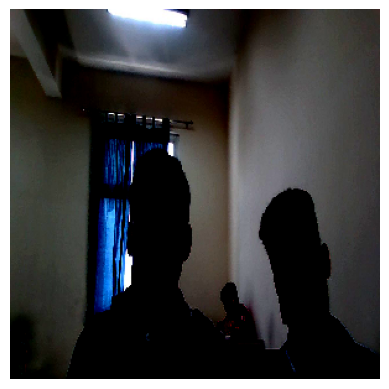

Generated Caption: man in red shirt and black shirt is standing in front of crowd


In [58]:
def generate_caption_single_image(filename):
    img = load_img(filename, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    features = cnn_model.predict(img)
    in_text = 'startseq'
    for i in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        pred = rnn_model.predict([features, sequence], verbose=0)
        pred = np.argmax(pred)
        word = index_to_word[pred]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return img[0], in_text

# Ask the user to provide the path of the input image
image_path = input("Enter the path of the input image: ")

# Generate caption for the image
image, caption = generate_caption_single_image(image_path)

# Remove startseq and endseq tokens from the caption
caption = ' '.join(caption.split()[1:-1])

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Print the generated caption
print("Generated Caption:", caption)
